# East Texas Temp Predict: A Data Product to Mitigate Crop Loss

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2_score
import pickle
import warnings
warnings.filterwarnings('ignore') # Ignores warnings about future depreciation


### Data provided by:
National Centers for Environmental Information

https://www.ncei.noaa.gov/cdo-web/datasets/GHCND/locations/CITY:US480034/detail

In [2]:
# Using pandas, reads csv file and creates a dataframe
source_weather_data = pd.read_csv('CS-Data-modified.csv')

In [3]:
source_weather_data.head()

,STATION,NAME,DATE,DAPR,MDPR,MDSF,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS
0,USC00414525,"JACKSONVILLE, TX US",1960-02-01,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN
1,USC00414525,"JACKSONVILLE, TX US",1960-02-02,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN
2,USC00414525,"JACKSONVILLE, TX US",1960-02-03,NaN,NaN,NaN,1.5,0.0,0.0,63.0,44.0,46.0
3,USC00414525,"JACKSONVILLE, TX US",1960-02-04,NaN,NaN,NaN,0.0,0.0,0.0,53.0,43.0,49.0
4,USC00414525,"JACKSONVILLE, TX US",1960-02-05,NaN,NaN,NaN,0.0,0.0,0.0,49.0,40.0,46.0


# Cleaning and Transforming Data
The date field was converted to datetime objects and assigned new fields, 'MONTH' and 'DAY'. All rows containing NaN values were dropped. A new column, called 'RAIN', was created using the 'PRCP' column. Any values in the 'PRCP' column greater than zero were assigned a value of 1. Otherwise, they remained as zero to indicate that there was no precipitation that day. 

In [4]:
# DATE fields will need to be converted to datetime objects
source_weather_data['DATE'] = pd.to_datetime(source_weather_data['DATE'])
source_weather_data.loc[:, 'MONTH'] = source_weather_data['DATE'].dt.month
source_weather_data.loc[:, 'DAY'] = source_weather_data['DATE'].dt.day

In [5]:
# Columns used for to clean and transform final dataframe
columns_used = ['MONTH', 'DAY', 'PRCP', 'TMAX', 'TMIN']

In [6]:
# Dataframe used for transformation
weather_data = source_weather_data[columns_used]

In [7]:
# Preview of dataframe
weather_data

,MONTH,DAY,PRCP,TMAX,TMIN
0,2,1,0.00,NaN,NaN
1,2,2,0.00,NaN,NaN
2,2,3,1.50,63.0,44.0
3,2,4,0.00,53.0,43.0
4,2,5,0.00,49.0,40.0
...,...,...,...,...,...
20711,12,27,0.00,51.0,23.0
20712,12,28,0.00,72.0,24.0
20713,12,29,0.00,72.0,64.0
20714,12,30,1.85,71.0,61.0


In [8]:
# Cleaning up NaN values and preview to show that changes were made
weather_data = weather_data.dropna()
weather_data

,MONTH,DAY,PRCP,TMAX,TMIN
2,2,3,1.50,63.0,44.0
3,2,4,0.00,53.0,43.0
4,2,5,0.00,49.0,40.0
5,2,6,0.00,62.0,33.0
6,2,7,0.00,64.0,38.0
...,...,...,...,...,...
20710,12,26,0.00,50.0,16.0
20711,12,27,0.00,51.0,23.0
20712,12,28,0.00,72.0,24.0
20713,12,29,0.00,72.0,64.0


In [9]:
# Limit is the threshold of precipitation for RAIN column.
limit = 0

weather_data = weather_data.copy()

# Any value greater than limit will be assigned a 1
weather_data['RAIN'] = np.where(weather_data['PRCP'] > limit, 1, 0)

columns_used = ['MONTH', 'DAY','TMIN', 'TMAX', 'RAIN']

weather_data

,MONTH,DAY,PRCP,TMAX,TMIN,RAIN
2,2,3,1.50,63.0,44.0,1
3,2,4,0.00,53.0,43.0,0
4,2,5,0.00,49.0,40.0,0
5,2,6,0.00,62.0,33.0,0
6,2,7,0.00,64.0,38.0,0
...,...,...,...,...,...,...
20710,12,26,0.00,50.0,16.0,0
20711,12,27,0.00,51.0,23.0,0
20712,12,28,0.00,72.0,24.0,0
20713,12,29,0.00,72.0,64.0,0


### Daily Minimum Temperature By Month
#### Heatmap displays the months and days crops are at most risk of cold related damgage in blue.
January, February, March, November, and December are represented as months with the lowest minimum temperatures.

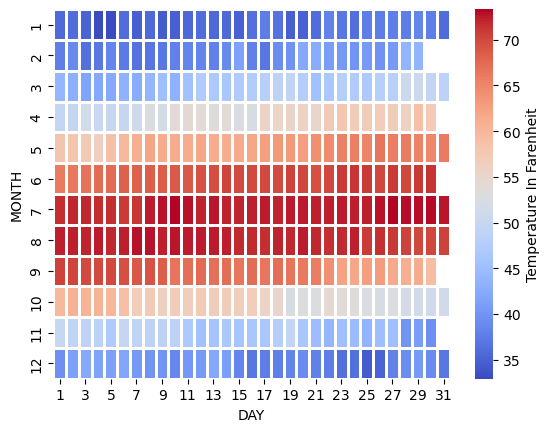

In [10]:
heatmap_wd = weather_data.pivot_table(index='MONTH', columns='DAY', values='TMIN');
sns.heatmap(heatmap_wd, cmap='coolwarm', linecolor='white', linewidths=1, cbar_kws={'label': 'Temperature In Farenheit'});

# Building the models

In [11]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor

# Setup random seed
np.random.seed(32)



# Creating the data
weather_df = weather_data[columns_used]

# TMIN will be the predicted value
X = weather_df.drop("TMIN", axis=1)
y = weather_df["TMIN"]

# Splitting data into training and test sets.
# 80% of the data is allocated to train the model while the reamining 20% is used for testing the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Bagging Regressor Model

In [12]:
# Fit model
model_BR = BaggingRegressor(max_features= 1.0, max_samples= 0.15, n_estimators= 200, random_state=32);
model_BR.fit(X_train, y_train);



In [13]:
model_BR.score(X_train, y_train)

0.8631946703286788

In [14]:
model_BR.score(X_test, y_test)

0.8161610409274824

### Random Forest Regressor Model

In [15]:
model_RFR = RandomForestRegressor(n_estimators=200, random_state=32)
model_RFR.fit(X_train, y_train);

In [16]:
model_RFR.score(X_train, y_train)

0.9300114194885294

In [17]:
model_RFR.score(X_test, y_test)

0.7746754453294505

### Support Vector Regression Model

In [18]:
model_SVR = SVR(kernel='linear', C=1.0, epsilon=0.1)
model_SVR.fit(X_train, y_train);

In [19]:
model_SVR.score(X_train, y_train)

0.7773519146371262

In [20]:
model_SVR.score(X_test, y_test)

0.7741289594725028

# Evaluation Metrics
The models were evaluated using both Mean Absolute Error (MAE) and R² score metrics. MAE provides a measurement for the average amplitude of error in the predictions without bias for direction. A MAE score of zero indicates the model is making perfect predictions. The R² score is a measurement of variance between the dependent variable (minimum temperature) and independent variables (rainfall, daily high temperature, month, and day). An R² score of 1 indicates that the model's dependent variable is perfectly explained by the independent variables.

In [21]:
y_true = y_test

### Bagging Regressor

In [22]:
# mean absolute error: BaggingRegressor Model
y_pred = model_BR.predict(X_test)
bagging_regressor_mae =mae(y_true, y_pred)
print(bagging_regressor_mae)

5.0300525439803625


In [23]:
# R² score: BaggingRegressor Model
bagging_regressor_r2 = r2_score(y_true, y_pred);
print(bagging_regressor_r2)


0.8161610409274824


### Random Forest Regressor

In [24]:
# mean absolute error: Random Forest Regressor
y_pred = model_RFR.predict(X_test)
random_forest_mae = mae(y_true, y_pred)
print(random_forest_mae)

5.52425460145645


In [25]:
# R² score: Random Forest Regressor
random_forest_r2 = r2_score(y_true, y_pred);
print(random_forest_r2)

0.7746754453294505


### Support Vector Regression

In [26]:
# mean absolute error: Support Vector Regression
y_pred = model_SVR.predict(X_test)
svr_mae = mae(y_true, y_pred)
print(svr_mae)

5.746338742400952


In [27]:
# R² score: Support Vector Regression
svr_r2 = r2_score(y_true, y_pred);
print(svr_r2)

0.7741289594725028


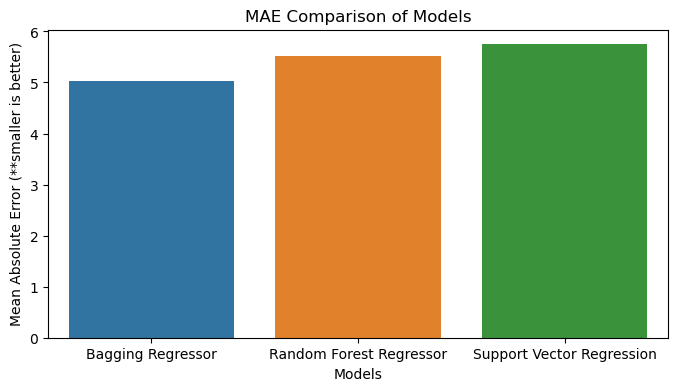

In [28]:
models = ['Bagging Regressor', 'Random Forest Regressor', 'Support Vector Regression']
mae_scores = [bagging_regressor_mae, random_forest_mae, svr_mae]
plt.figure(figsize=(8,4));
sns.barplot(x=models, y=mae_scores);
plt.xlabel('Models');
plt.ylabel('Mean Absolute Error (**smaller is better)');
plt.title('MAE Comparison of Models');

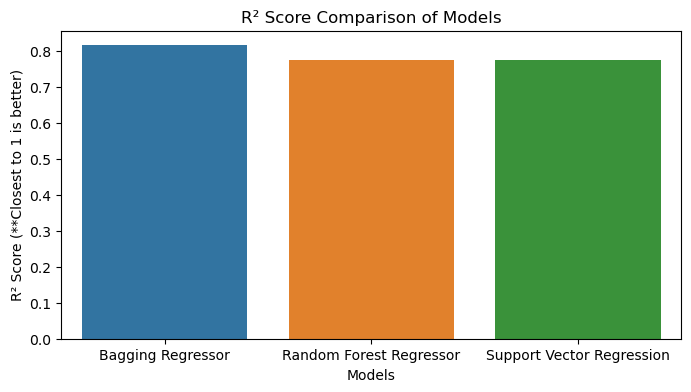

In [29]:
models = ['Bagging Regressor', 'Random Forest Regressor', 'Support Vector Regression']
r2_scores = [bagging_regressor_r2, random_forest_r2, svr_r2]
plt.figure(figsize=(8,4));
sns.barplot(x=models, y=r2_scores);
plt.xlabel('Models');
plt.ylabel('R² Score (**Closest to 1 is better)');
plt.title('R² Score Comparison of Models');

## Results and Selection:
      

Upon analysis of R² and MAE, the Bagging Regressor model will be the selected model as it outperforms both, Random Forest Regressor, and Support Vector Regression models.

#### Scatterplot Visualization of Bagging Regressor Model

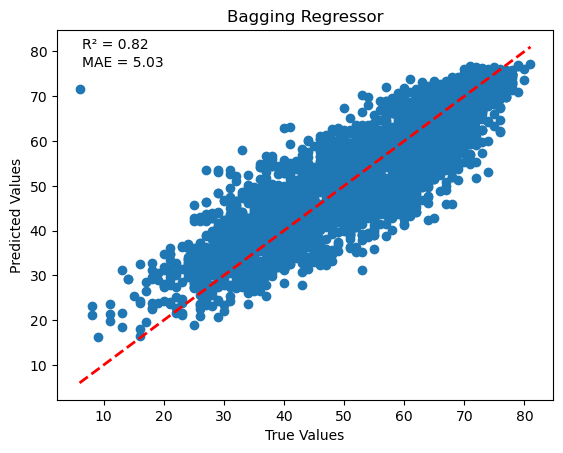

In [30]:
y_pred = model_BR.predict(X_test);
plt.scatter(y_test, y_pred);
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', lw=2, color='red');
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Bagging Regressor')
plt.annotate('R² = {:.2f}'.format(bagging_regressor_r2), xy=(0.05,0.95), xycoords='axes fraction');
plt.annotate('MAE = {:.2f}'.format(bagging_regressor_mae), xy=(0.05, 0.90), xycoords='axes fraction');

#### Histogram Visualization of Bagging Regressor Model

Residual analysis is performed to determine the quality of the Bagging Regressor Model. Ideally, all values would be as close to zero as possible. Although there are some outliers, the majority of residuals are centered around zero which indicates good performance.

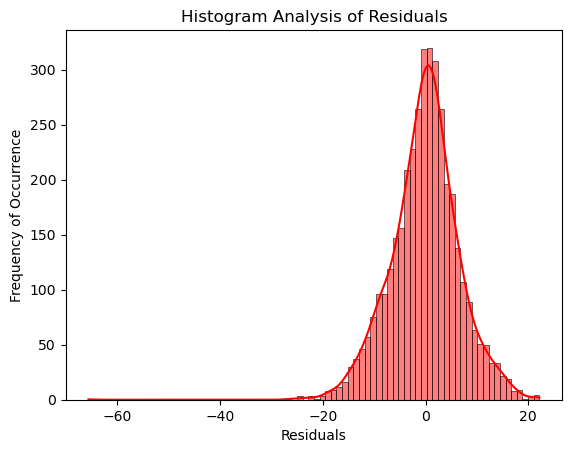

In [31]:
residuals = y_test - y_pred
sns.histplot(residuals, bins=80, color='red', kde=True);
plt.xlabel('Residuals');
plt.ylabel('Frequency of Occurrence');
plt.title('Histogram Analysis of Residuals');

# Save and Load Model 

In [32]:
# Saves/Dumps Bagging Regressor model as f
import pickle 
with open('pkl_model', 'wb') as f:
    pickle.dump(model_BR,f)

In [33]:
# Loads Bagging Regressor model for use in application
import pickle
with open('pkl_model', 'rb') as f:
    pkl_m = pickle.load(f)

In [34]:
## Future Implementation Using Average High Temperature
#daily_av_high = {}
#for month in range(1, 13):
#    for day in range(1, 32):
#        days_of_month = weather_df[(weather_df['MONTH'] == month) & (weather_df['DAY'] == day)]        
#        if not days_of_month.empty:            
#            av_high = int(days_of_month['TMAX'].mean())                
#            daily_av_high[(month, day)] = av_high
#            
#daily_av_high.get((10,5))            

In [35]:
# Returns number of days in the month based on selected number corresponding to the selected month.
# To include leap years, Feb. is defaulted at 29 days.
def delta_days(month):
    if month in[1, 3, 5, 7, 8, 10, 12]:
        return 31
    elif month in[4, 6, 9, 11]:
        return 30
    elif month == 2:
        return 29

In [36]:
# Function uses model to check the minimum temperature for a selected day. If the low temperature is at or below
# freezing(32 degrees F), then makes a recommendation on whether or not to protect crops. 
def min_temp_prediction(month, day, tmax, rain):
    is_rain = 0
    if rain == 'Yes':
        is_rain = 1
    else:
        is_rain = 0
    #prediction_data = {'MONTH': month,'DAY': day,'TMAX': daily_av_high.get((month,day)),'RAIN': rain}
    prediction_data = {'MONTH': month,'DAY': day,'TMAX': tmax,'RAIN': is_rain}
    prediction_df = pd.DataFrame([prediction_data])
    min_temp_array = pkl_m.predict(prediction_df)
    if min_temp_array[0] <=32:
        print('Expected low of {} degrees farenheit. Frost protection for crops is advised'.format(int(min_temp_array[0])))
    else:
        print('Expected low of {} degrees farenheit. Crops should not require frost protection'.format(int(min_temp_array[0])))
    sns.scatterplot(x =weather_df['TMAX'], y=weather_df['TMIN'], alpha=0.5, label='Temperature Data (Fahrenheit)')
    plt.scatter(tmax, int(min_temp_array[0]), color='yellow', marker='*', label='Predicted Low Temperature')
    plt.xlabel('Daily High Temperature')
    plt.ylabel('Daily Low Temperature')
    plt.legend()
    day_slider.max = delta_days(month) #Included to adjust the days of each month as widgets.interact() can only pass one method
    return    


In [37]:
month_slider = widgets.IntSlider(value = 1, min=1, max=12, description='Month:');
day_slider = widgets.IntSlider(value=1, min=1, max=31, description='Day:');
max_temp_slider = widgets.IntSlider(value=60, min=0, max=110, description='Daily High:');
rain_dropdown = widgets.Dropdown(options=[('Yes'),('No')], description='Rainfall');
widgets.interact(min_temp_prediction, month=month_slider, day=day_slider, tmax=max_temp_slider, rain=rain_dropdown);    





interactive(children=(IntSlider(value=1, description='Month:', max=12, min=1), IntSlider(value=1, description=…